## (Miles Per Gallon) MPG Prediction
The purpose of this notebook is to predict the Miles Per Gallon (MPG) of a vehicle based on certain input parameters pertaining to the vehicle. The dataset used in this notebook is retrieved from UCI data repository https://archive.ics.uci.edu/ml/datasets/auto+mpg.

A Vehicle's parameters such as the Weight, Cylinder Capacity, Fuel Type and Cylinder count can be used to calculate the MPG of a Vehicle. While the driving conditions impact the actual MPG on road, these parameters could be useful for a potential buyer who is conscious of the fuel economy. Today's advancements in Vehicle technology makes these parameters a little less useful in determining the MPG. However, the dataset has observations from the 70s and 80s where technology was less advance than today.

This ML project uses Python language to perform ML based prediction of MPG. 

The Python packages required for this project are imported as the first step.

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, PredictionErrorDisplay
import seaborn as sns
from matplotlib import pyplot as plt

The dataset is already downloaded to a local folder. The dataset is loaded into the program and is split into training and testing sets.

In [2]:
rng = 5
dataset = pd.read_csv("auto-mpg.csv", header = 0)

X = dataset.copy()
y = X.pop('mpg')

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.15, random_state=rng)


Retrieve the Features dataset(X) information to understand the columns, their types and associated counts.

In [3]:
X_train_orig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 316 to 355
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     338 non-null    int64  
 1   displacement  338 non-null    float64
 2   horsepower    338 non-null    object 
 3   weight        338 non-null    int64  
 4   acceleration  338 non-null    float64
 5   modelyear     338 non-null    int64  
 6   origin        338 non-null    int64  
 7   name          338 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 23.8+ KB


The above summary shows that the features Horsepower and Name are object types, while the rest are numeric types. Retrieve the top few rows of the features dataset to understand this better.

In [4]:
X_train_orig.head(10)

,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,name
316,6,225.0,90,3381,18.7,80,1,dodge aspen
321,4,108.0,75,2265,15.2,80,3,toyota corolla
0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
60,4,140.0,90,2408,19.5,72,1,chevrolet vega
234,4,151.0,88,2740,16.0,77,1,pontiac sunbird coupe
242,4,121.0,110,2600,12.8,77,2,bmw 320i
101,6,198.0,95,2904,16.0,73,1,plymouth duster
132,4,140.0,75,2542,17.0,74,1,chevrolet vega
368,4,112.0,88,2640,18.6,82,1,chevrolet cavalier wagon
298,8,350.0,125,3900,17.4,79,1,cadillac eldorado


The above result indicates that while Name feature contains text, the horsepower feature contains continuous numbers. The reason it is shown as object type is because it contains missing values denoted as "?". As part of pre-processing, this needs to be rectified. Also, the Cylinders, ModelYear and Origin features contain discrete numbers. During pre-processing, this needs to one-hot encoded. Two array variables are created to hold the dicrete and continuous feature names.

In [5]:
continuous_features = np.array(['displacement','horsepower','weight','acceleration'])
discrete_features = np.array(['cylinders','origin','modelyear'])

#### Exploratory Data Analysis

Understand the relationship between the continuous variables and the target. For the sake of data exploration the Horsepower observations that have "?" as value are dropped.

<Axes: xlabel='weight', ylabel='mpg'>

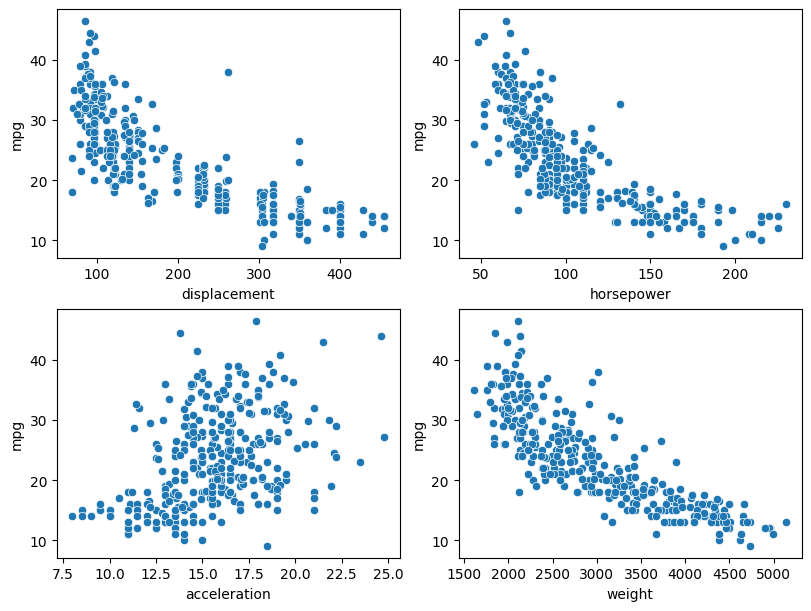

In [6]:
dataset_train = pd.concat([X_train_orig, y_train_orig], axis=1)
dataset_train = dataset_train[dataset_train.horsepower != '?'] 
dataset_train.loc[:,'horsepower'] = dataset_train.horsepower.astype('float64')
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig1.set_size_inches(8,6)
fig1.set_layout_engine('compressed')
sns.scatterplot(x=dataset_train.displacement, y=dataset_train.mpg, ax = ax1)
sns.scatterplot(x=dataset_train.horsepower, y=dataset_train.mpg, ax = ax2)
sns.scatterplot(x=dataset_train.acceleration, y=dataset_train.mpg, ax = ax3)
sns.scatterplot(x=dataset_train.weight, y=dataset_train.mpg, ax = ax4)

The above plots indicate that MPG reduces as Horsepower, Displacement and Weight increase. However, Acceleration feature doesn't seem to have clear correlation with MPG. It also indicates that there could be some outliers. These can be statistically verified later by computing the Mutual Information.

Understand the relationship between the categorical features and continuous variables.

<Axes: xlabel='cylinders', ylabel='mpg'>

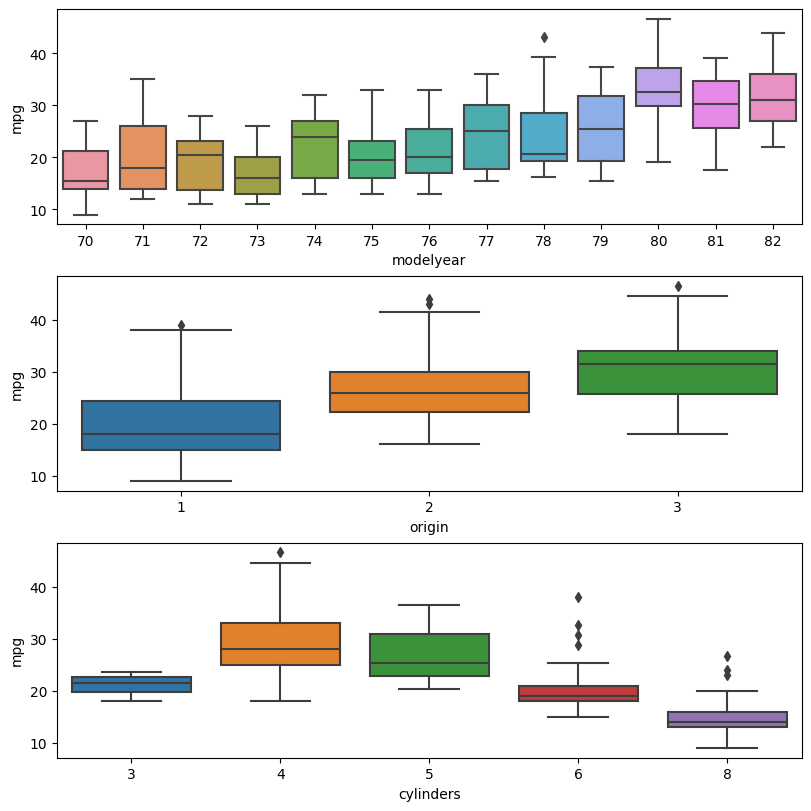

In [7]:
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig2.set_size_inches(8,8)
fig2.set_layout_engine('compressed')
sns.boxplot(x=dataset_train.modelyear, y = dataset_train.mpg, ax=ax1)
sns.boxplot(x=dataset_train.origin, y = dataset_train.mpg, ax=ax2)
sns.boxplot(x=dataset_train.cylinders, y = dataset_train.mpg, ax=ax3)

The above box plots indicate model year does not have a linear correlation with mpg, while origin seem to have linear correlation with mpg. The mpg reduces as the number of cylinders increase, provided the number is cylinders is more than three. However, all these features seem to have perceptible impact on the mpg. To verify the above theoretical inferences, the Mutual Information between the features and target is calculated. Since the name field is text and cannot be one-hot encoded, it is excluded from calculating the mutual information.

<BarContainer object of 7 artists>

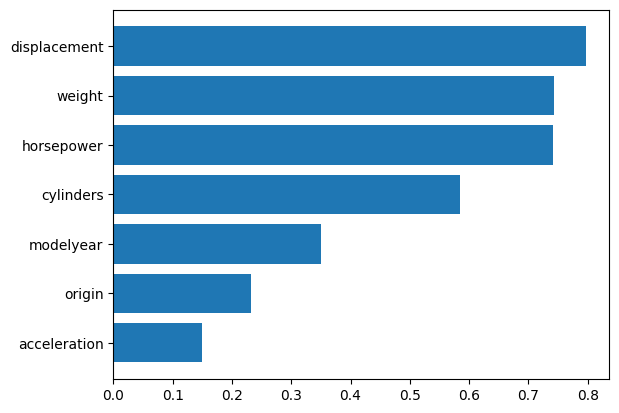

In [8]:
discrete_mask = [len(np.where(discrete_features == col)[0]) > 0 for col in dataset_train.columns.drop(['mpg','name'])]
mutualinfo = mutual_info_regression(X=dataset_train.loc[:,dataset_train.columns.drop(['name','mpg'])], y=dataset_train.mpg, discrete_features=discrete_mask
                                    , random_state=rng)
plot_mi_df = pd.DataFrame()
plot_mi_df['features'] = dataset_train.columns.drop(['name','mpg'])
plot_mi_df['mutualinfo'] = pd.Series(mutualinfo)
plot_mi_df = plot_mi_df.sort_values(by='mutualinfo')
plt.barh(plot_mi_df['features'], plot_mi_df['mutualinfo'])

The above plot indicates displacement plays the major role, among the other features, in determining the mpg. While, acceleration did not show any correlation when plotted with mpg previously, the above plot indicates it does play a minor role in determining the target. The mutual information of the features are not negligible and hence all the features will be considered in determining the target.

As part of pre-processing pipeline, the cylinders and origin will be one-hot encoded. Since the dataset is not huge and model year has many categories, it is considered as a continuous feature and hence not one-hot encoded. It is assumed that there could be one percent outlier in the dataset and hence, *IsolationForest* is used as part of pre-processing to remove one-percent of data as outliers. Also, the input dataset is scaled to have a value between 0 and 1 and the target is transformed using *TransformedTargetRegressor*.

Make ready the train and test data.

In [9]:
X_train = X_train_orig.copy()
X_test = X_test_orig.copy()
y_train = y_train_orig.copy()
y_test = y_test_orig.copy()

Create python routines that will be used as part of pre-processing.

In [10]:
def transform_hp(X, replacement_value):
    X.loc[X['horsepower'] == "?", 'horsepower'] = replacement_value
    X.loc[:,'horsepower'] = X.loc[:,'horsepower'].astype('float32')
    return X

def create_features(X):
    X.loc[:,'diesel'] = [1 if isdiesel == 1 else 0 for isdiesel in X['name'].str.contains('diesel')]
    return X

def clip_outliers(X, y):
    ee_outlier = IsolationForest(contamination=0.01, random_state=rng)
    outliers = ee_outlier.fit_predict(X)
    X, y = X[outliers != -1, :], y[outliers != -1]
    return X, y

The *transform_hp* routine is used to update horespower feature with the *replacement_value* where the value is "?". 

Diesel vehicles tend to provide better mpg than vehicles that run on gasoline. Hence, a features is added indicating if the vehicle runs on diesel or gasoline. This feature is created based on the name of the vehicle which contains the word *diesel*. The *create_features* routine performs this task.

The *clip_outliers* routine clips 1% of outliers from the input dataset.

Create the pre-processing pipeline based on the above routines.



In [11]:
ohencoder = OneHotEncoder(min_frequency=1, handle_unknown='infrequent_if_exist')
median_horsepower = dataset_train.horsepower.median()

preprocess_pipeline = Pipeline([
    ('impute_horsepower', FunctionTransformer(func = transform_hp, 
                                              kw_args = { 'replacement_value' : median_horsepower })),
    ('create_features', FunctionTransformer(create_features)),
    ('transform_features', ColumnTransformer(
                        transformers = [('drop_col','drop',['name']),
                                        ('onehotencode', ohencoder, ['origin','cylinders'])],
                        remainder = MinMaxScaler()
    ))
])

Preprocess the training features and target.

In [12]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_train, y_train = clip_outliers(X_train, y_train)

Hyper parameter tuning is performed using *GridSearchCV*. *Mean Absolute Error* is used as the loss function to minimize the loss. The target is transformed using *PowerTransformer*. Based on the cross-validation of hyper parameters the best estimator is extracted.

In [13]:
paramGrid = { 
    'regressor__n_estimators': np.arange(50, 150, 10),
    'regressor__subsample': np.arange(0.1, 1.0, 0.1),
    'regressor__min_samples_split': np.arange(2, 5, 1),
    'regressor__max_depth': np.arange(2, 6, 1)
}
est_cv = GridSearchCV(
                TransformedTargetRegressor(regressor = GradientBoostingRegressor(random_state=rng),
                                                transformer = PowerTransformer(method = 'yeo-johnson'))
                , paramGrid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
est_cv.fit(X_train, y_train)

estimator = est_cv.best_estimator_

Perform pre-processing on the test dataset as well and make predictions based on the best estimator extracted as a result of hyper parameter tuning. Perform predictions on both the test and training datasets to understand if there is any over-fitting.

In [14]:
X_test = preprocess_pipeline.transform(X_test)
y_predict = estimator.predict(X_test)
y_predict_train = estimator.predict(X_train)

Print the *Mean Absolute Error* for the predictions made on both the training and testing datasets. Perform cross-validation on the training data with the best estimator and print the scores.

In [15]:
print(mean_absolute_error(y_test, y_predict))
print(mean_absolute_error(y_train, y_predict_train))
print([np.sqrt(np.abs(score)) for score in cross_val_score(estimator, X_train, y_train, scoring = "neg_mean_absolute_error")])

1.836047617993495
0.5669977756608693
[1.4734377654410402, 1.33785208974908, 1.4142110980433602, 1.2915474326580612, 1.2708145929927104]


The above results indicate some level of over-fitting as the prediction on test dataset shows a MAE of 1.836, while the predictions on training set has a MAE of only 0.567. The 5-fold cross-validation on training set shows a MAE of around 1.35 on average. Since the dataset used is old there could be some manual errors resulting in incorrect inputs. Also, the dataset only has 400 observations. Perhaps, lower MAE can be achieved if there are more observations. The actual-vs-predicted plot is drawn to visually understand the difference in predictions.

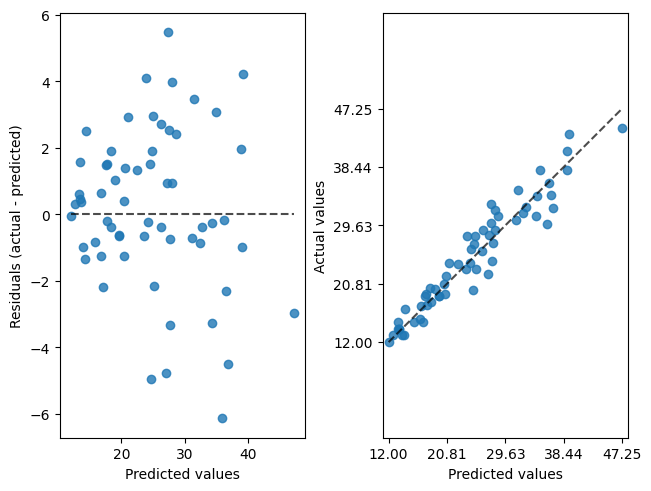

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_layout_engine('compressed')
PredictionErrorDisplay.from_predictions(y_test, y_predict, ax=ax1)
PredictionErrorDisplay.from_predictions(y_test, y_predict, kind='actual_vs_predicted', ax=ax2)
plt.show()

The first plot indicates the difference between predicted value and actual value varies maximum by a factor of 6. Both the plots indicate the difference increases for higher values of mpg. With more data and a more exhaustive hyper parameter tuning, perhaps a better result could be achieved.

Thanks for reading.